In [1]:
import numpy as np
import MDAnalysis as mda
import timeit
import matplotlib.pyplot as plt  
import copy
import scipy.special as sp

suw = mda.Universe("swater_prd.tpr","swater_prd.xtc")
uw = mda.Universe("water2_prd.tpr", "water2_prd.xtc")
uh = mda.Universe("hexaice_prd.tpr", "hexaice_prd.xtc")
uc = mda.Universe("cubicice_prd.tpr","cubicice_prd.xtc")

swbox = np.array([23.0, 23.0, 23.0])
wbox = np.array([30.0,   30.0,   30.0])
hbox = np.array([31.5251,   29.6340,   36.4161])
cbox = np.array([32.0350,   32.0350,   32.0350])

In [2]:
def cart2sph(x, y, z):
    r = np.sqrt(x*x+y*y+z*z)
    cos_theta = z/r
    theta = np.arccos(cos_theta)
    cos_phi = x/(np.sin(theta)*r)

    #Due to machine precision, sometimes cos_phi = +-1.0000001
    if cos_phi > 1:
        cos_phi = 1
    if cos_phi < -1:
        cos_phi = -1
    
    phi = np.arccos(cos_phi)
    if y < 0:
        phi = 2*np.pi-phi
    return theta, phi

In [3]:
#Let's get theta and phi between i and j
#for i = 0 j = 100 rij = r(j) - r(i)
def angle(i,j,o,box):
    ii = copy.copy(o[i])
    jj = copy.copy(o[j])

#     print(ii,jj)

    for k in range (3):
        if abs(ii[k]-jj[k]) > box[k]/2:
            if ii[k] > box[k]/2:
                jj[k] = jj[k] + box[k]
            else:
                jj[k] = jj[k] - box[k]

    h = jj-ii
#     print(jj-ii)
#     print(np.linalg.norm(h))
    theta, phi = cart2sph(h[0], h[1], h[2])
    return theta, phi

In [4]:
#Let's get q_lm(i)
#neighborlist (n,)
def steinhardt(m,l,i,neighborlist,o,box):
    n = neighborlist.size
    q_lm_i = 0
    for k in range(n):
        theta, phi = angle(i,np.intc(neighborlist[k]),o,box)
        a = sp.sph_harm(m,l,phi,theta)
        q_lm_i = a + q_lm_i
    q_lm_i = q_lm_i/n
    return q_lm_i

In [5]:
def chill(pos_A, pos_B, box, x_max, n_bins, cutoff, l):
    o = pos_A
    N = o.shape[0] # number of molecules
    dist = np.abs(o[:, np.newaxis, :] - o)
    ddist = np.abs(dist - box)
    dist = np.minimum(dist, ddist)
    dist = np.reshape(dist*dist, (N*N,3))
    dist = np.sum(dist,axis = 1)
    dist = np.sqrt(dist)



    neighbor_list = []


    for i in range(N):
        distij = dist[i*(N):(i+1)*(N)] #make (N,) distance vector
        list = np.argsort(distij)
        distij = np.sort(distij)


        k = 1
        arr = []
        while distij[k] < cutoff:
            arr += [list[k]]
            k += 1
        arr = np.array(arr)
        neighbor_list += [arr]
    
#     neighbor_number = np.zeros((N,1))
#     for i in range(N):
#         neighbor_number[i] = neighbor_list[i].shape[0]

#     sort_neighbor_number = np.sort(neighbor_number)

    op = []
    for i in range(N):
        arr = []
        ni = neighbor_list[i]
        for j in range(ni.shape[0]):
            qi = []
            qj = []
            qiqj = qiqi = qjqj =0
            for m in range(-l,l+1):
                qi = qi + [steinhardt(m,l,i,neighbor_list[i],o,box)]
                qj = qj + [steinhardt(m,l,ni[j],neighbor_list[ni[j]],o,box)]
            
            for m in range(-l,l+1):
                qiqj += qi[m]*np.conj(qj[m])
                qiqi += qi[m]*np.conj(qi[m])
                qjqj += qj[m]*np.conj(qj[m])
            cij = np.real(qiqj/np.sqrt(qiqi)/np.sqrt(qjqj))
            arr += [cij]
        arr = np.array(arr)
        op += [arr]
            
        

    opp = op[0]        
    for i in range(N-1):
        opp = np.append(opp,op[i+1])



    
    #binning step
    bins = np.linspace(-1, x_max, n_bins)
    dr = bins[1] - bins[0]
    opp = np.sort(opp)
    
    p = 0
    i = 0
    m = 0
    nr = np.zeros(n_bins)
    rdf = np.zeros(n_bins)

    while True:
        while opp[i] > bins[p]:
            nr[p] = m
            p = p+1
            if p== len(nr):
                break
        else:
            i = i+1
            m = m+1
            if i == len(opp):
                break
        if p == len(nr):
            break
            
    for i in range (n_bins-1):
        rdf[i+1] = nr[i+1] - nr[i]
        if rdf[i+1] <0:
            rdf[i+1] = rdf[i+1] + opp.shape[0]
        
    

    return bins, rdf, op #neighbor_number

In [6]:
def op_average(u, array, fs_atom_name, sn_atom_name , box, x_max, n_bins, cutoff, l):

    '''
    Input:
      array(numpy.ndarray) : (n_time_frames)  ex) [0,100,200,300...,1000]
      
    output:
      bins(numpy.ndarray) : (n_bins,) array of bins
      gr_average(numpy.ndarray) : (n_bins, ) radial distribution function
      nr_average(numpy.ndarray) : (n_bins, ) number of cumulative molecules
    
    '''
    
    u.trajectory[0]
    p = u.select_atoms(fs_atom_name)
    o = p.atoms.positions
    N = o.shape[0] # number of molecules

    
    rdf__ = np.zeros(n_bins)
#     opp = np.zeros((N,))
    n_bins = n_bins
    
    for i in array:
        u.trajectory[np.int(i)]
        p = u.select_atoms(fs_atom_name)
        pp = u.select_atoms(sn_atom_name)
        bins, rdf_, op = chill(p.atoms.positions, pp.atoms.positions, box, x_max, n_bins, cutoff, l)
        rdf__ += rdf_
#         opp += op

    
    return bins, rdf__/len(array)#, op#opp/len(array)

In [7]:
def discrim(op):
    n = len(op)
    c = []
    
    for i in range(n):
        arr = []
        oi = op[i]
        
        for j in range(oi.shape[0]):
            if -0.35< oi[j] <0.25:
                arr += ['E']
            elif oi[j] < -0.8:
                arr +=['S']
            else:
                arr +=['O']
        c += [arr]
    return c
    

In [8]:
def discrim(op):
    n = len(op)
    c = []
    
    for i in range(n):
        arr = []
        oi = op[i]
        
        for j in range(oi.shape[0]):
            if -0.35< oi[j] <0.25:
                arr += ['E']
            elif oi[j] < -0.8:
                arr +=['S']
            else:
                arr +=['O']
        c += [arr]
        
    
    hexa = 0
    cubic = 0
    water = 0
    
    for i in range(n):
        arr = []
        ci = c[i]
        
        e = 0
        s = 0
        for j in range(len(ci)):
            if ci[j] == 'E':
                e +=1
            elif ci[j] =='S':
                s +=1
        if e == 0 and s ==4:
            cubic += 1
        elif e ==1 and s ==3:
            hexa += 1
        else:
            water += 1
                
    
    return c,hexa,cubic,water

In [32]:
uh.trajectory[50]
p = uh.select_atoms('name OW')
o = p.atoms.positions
bins,rdf, op = chill(o, o, hbox, 1, 50, 3.5, 3)
c,hexa,cubic,water = discrim(op)
print(hexa,cubic,water)

1019 0 5


In [33]:
uw.trajectory[50]
p = uw.select_atoms('name OW')
o = p.atoms.positions
bins,rdf, op = chill(o, o, wbox, 1, 50, 3.5, 3)
c,hexa,cubic,water = discrim(op)
print(hexa,cubic,water)

2 0 907


In [34]:
uc.trajectory[50]
p = uc.select_atoms('name OW')
o = p.atoms.positions
bins,rdf, op = chill(o, o, cbox, 1, 50, 3.5, 3)
c,hexa,cubic,water = discrim(op)
print(hexa,cubic,water)

0 1000 0


In [24]:
print(c)

[['S', 'S', 'E', 'S'], ['S', 'S', 'S', 'E'], ['S', 'E', 'S', 'S'], ['S', 'S', 'E', 'S'], ['S', 'S', 'E', 'S'], ['E', 'S', 'S', 'S'], ['S', 'S', 'S', 'E'], ['S', 'E', 'S', 'S'], ['E', 'S', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'S', 'E', 'S'], ['S', 'E', 'S', 'S'], ['S', 'S', 'S', 'E'], ['S', 'S', 'E', 'S'], ['E', 'S', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'S', 'E', 'S'], ['S', 'S', 'S', 'E'], ['E', 'S', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'E', 'S', 'S'], ['E', 'S', 'S', 'S'], ['E', 'S', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'S', 'E', 'S'], ['S', 'S', 'S', 'E'], ['S', 'S', 'E', 'S'], ['E', 'S', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'S', 'E', 'S'], ['S', 'S', 'S', 'E'], ['S', 'S', 'E', 'S'], ['S', 'E', 'S', 'S'], ['E', 'S', 'S', 'S'], ['S', 'S', 'E', 'S'], ['E', 'S', 'S', 'S'], ['E', 'S', 'S', 'S'], ['S', 'E', 'S', 'S'], ['S', 'S', 'E', 'S'], ['E', 'S', 'S', 'S'], ['S', 'S'

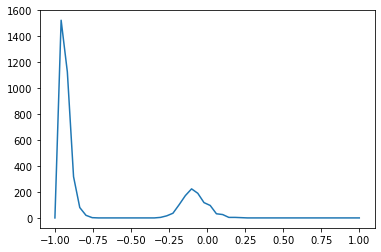

In [95]:
plt.plot(bins,rdf)

In [98]:
uw.trajectory[50]
p = uw.select_atoms('name OW')
o = p.atoms.positions
bins,rdf, opp, neighbor_list = chill(o, o, wbox, 1, 50, 3.5, 3)

[-0.45682049 -0.11243124 -0.26943606 ... -0.57106186 -0.19565831
  0.42753404]


In [115]:
wbins, wrdf_ = op_average(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 3.5, 3)

[-0.22655552 -0.05902927 -0.61242125 ...  0.27637912 -0.40876704
 -0.04482187]
[-0.58735736 -0.32516937 -0.58052762 ...  0.35830158 -0.30829345
  0.36840588]
[-0.60431593 -0.55555063 -0.1552833  ... -0.67752475 -0.79764726
  0.16386093]
[-0.55209881 -0.29122806  0.07673445 ... -0.05460063 -0.2809042
 -0.8281832 ]
[-0.11608195 -0.44086338 -0.57439481 ... -0.33974765 -0.43628824
 -0.39589661]
[-0.56588805 -0.63406077  0.18017537 ... -0.54044139 -0.20272207
  0.00278502]
[-0.74823213 -0.56301328 -0.64851657 ... -0.33663844 -0.40194602
 -0.55997129]
[-0.33143013  0.31185559 -0.14209113 ... -0.18531068 -0.11182359
  0.26608398]
[-0.78019354 -0.57363544 -0.00627478 ... -0.0819523   0.09530213
 -0.18508507]
[ 0.20911494 -0.3694189   0.07144655 ... -0.1994432  -0.1774527
  0.0857248 ]
[-0.72461771 -0.66963056  0.00524181 ... -0.16890603 -0.20392932
 -0.54325779]
[-0.4642909  -0.47216425  0.20124175 ... -0.74008047 -0.19402631
  0.0916444 ]
[-0.26279851 -0.15765565 -0.09292704 ... -0.27048988 -

In [9]:
hbins, hrdf_ = op_average(uh, np.linspace(0,1000,20),"name OW", "name OW", hbox, 1, 50, 3.5, 3)

In [117]:
cbins, crdf_ = op_average(uc, np.linspace(0,1000,20),"name OW", "name OW", cbox, 1, 50, 3.5, 3)

[-0.96031155 -0.9939328  -0.97358338 ... -0.93902678 -0.96983928
 -0.96274429]
[-0.94007854 -0.87685029 -0.92867083 ... -0.96338071 -0.9727209
 -0.96764187]
[-0.96902489 -0.98201757 -0.98771923 ... -0.96487636 -0.97008363
 -0.9783991 ]
[-0.94726283 -0.87661404 -0.94757529 ... -0.88891939 -0.61029084
  0.30485936]
[-0.9633674  -0.92701686 -0.93319489 ... -0.9420509  -0.93486478
 -0.91987123]
[-0.91507741 -0.94989416 -0.92374211 ... -0.98137004 -0.96476623
 -0.97768222]
[-0.90494337 -0.95665253 -0.92182483 ... -0.94200711 -0.98406078
 -0.94552386]
[-0.94759074 -0.95119104 -0.97264793 ... -0.94885043 -0.96946962
 -0.95260143]
[-0.96043295 -0.95367856 -0.98738886 ... -0.85052268 -0.87499816
 -0.97747545]
[-0.88676953 -0.92790776 -0.94748342 ... -0.96999824 -0.97870686
 -0.9263787 ]
[-0.95004982 -0.86614944 -0.85689679 ... -0.95417449 -0.96596571
 -0.98130061]
[-0.97094282 -0.98552028 -0.98122164 ... -0.98614984 -0.96949659
 -0.95506368]
[-0.92070701 -0.97940024 -0.92827028 ... -0.97502512 

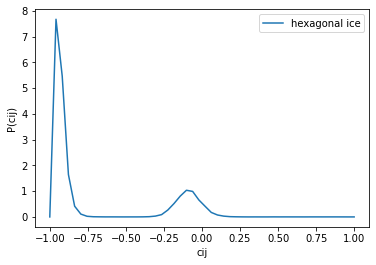

In [10]:

plt.plot(hbins, hrdf_/200, label='hexagonal ice')

plt.xlabel("cij")
plt.ylabel("P(cij)")

plt.legend()

In [13]:
np.sum(hrdf_[0:10]/200*0.04
print(hbins)

[-1.         -0.95918367 -0.91836735 -0.87755102 -0.83673469 -0.79591837
 -0.75510204 -0.71428571 -0.67346939 -0.63265306 -0.59183673 -0.55102041
 -0.51020408 -0.46938776 -0.42857143 -0.3877551  -0.34693878 -0.30612245
 -0.26530612 -0.2244898  -0.18367347 -0.14285714 -0.10204082 -0.06122449
 -0.02040816  0.02040816  0.06122449  0.10204082  0.14285714  0.18367347
  0.2244898   0.26530612  0.30612245  0.34693878  0.3877551   0.42857143
  0.46938776  0.51020408  0.55102041  0.59183673  0.63265306  0.67346939
  0.71428571  0.75510204  0.79591837  0.83673469  0.87755102  0.91836735
  0.95918367  1.        ]


In [16]:
print(np.sum(hrdf_[0:10]/200*0.041))
print(np.sum(hrdf_[12:30]/200*0.041))
print(np.sum(hrdf_)/200*0.041)

0.6294729999999998
0.209715
0.8399055


In [102]:
uc.trajectory[50]
p = uc.select_atoms('name OW')
o = p.atoms.positions
bins,rdf, opp, neighbor_list = chill(o, o, cbox, 1, 50, 3.5, 3)

[-0.91501523 -0.94810323 -0.97701862 ... -0.93343792 -0.95557401
 -0.92359049]


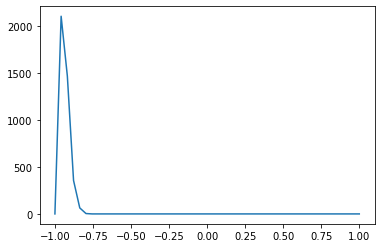

In [103]:
plt.plot(bins,rdf)

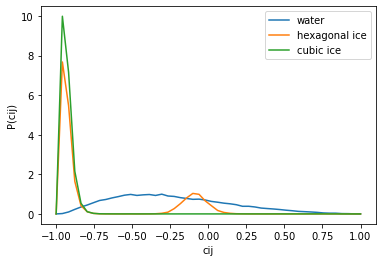

In [119]:
plt.plot(wbins, wrdf_/200, label='water')
plt.plot(hbins, hrdf_/200, label='hexagonal ice')
plt.plot(cbins,crdf_/200, label='cubic ice')
plt.xlabel("cij")
plt.ylabel("P(cij)")

plt.legend()

Text(0, 0.5, 'P(cij)')

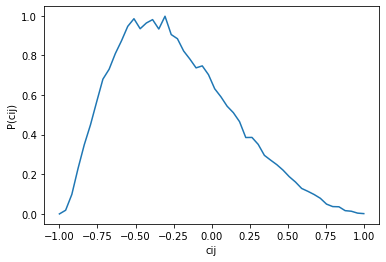

In [120]:
plt.plot(wbins, wrdf_/200, label='water')
plt.xlabel("cij")
plt.ylabel("P(cij)")


In [42]:
qi[0]*np.conj(qi[1])

(7-1j)

In [60]:
a = np.array([1,2,3])
b = np.array([3,4])


In [63]:
np.append(a,b)

array([1, 2, 3, 3, 4])

In [45]:
print(a,b,c)

0 0 0


In [72]:
c = a
for i in range(10):
    c = np.append(c,a)

In [73]:
c

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1,
       2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3])

In [6]:
phi = 2.0
theta = 3.0
a = sp.sph_harm(0,3,phi,theta)
print(a)

(-0.7020966389323088+0j)


In [18]:
def q(l,phi,theta):
    a = 0
    for m in range(-l,l+1):
        a += np.abs(sp.sph_harm(m,l,phi,theta))*np.abs(sp.sph_harm(m,l,phi,theta))

    return(np.sqrt(4*np.pi/(2l+1)*a))
        

In [22]:
a = q(4,2.0,3.0)
print(a)
a = q(4,2.0,3.0)
print(a)

1.3592112019016371
2.1294695806511315


In [ ]:
r1 : theta = 2.0, phi = 3.0+1.0
r2 : theta =1.0, phi = 4.0+1.0

In [31]:
def q(l,phi1,theta1,phi2,theta2):
    a = 0
    for m in range(-l,l+1):
        q = 1/2*(sp.sph_harm(m,l,phi1,theta1)+sp.sph_harm(m,l,phi2,theta2))
        a += np.abs(q)*np.abs(q)
    return(np.sqrt(4*np.pi/(2*l+1)*a))

In [45]:
theta1 = 0.0+1.0
phi1 = 0.0
theta2 = np.pi-1.0
phi2 = 0.0+np.pi
a = q(3,phi1,theta1,phi2,theta2)
print(a)

3.3018202619127863e-16


In [17]:
c = 1+2j
print(np.abs(c))

2.23606797749979


In [26]:
a = sp.sph_harm(-1,3,2.0,3.0)
print(abs(a))
a = sp.sph_harm(1,3,2.0,3.0)
print(a)

0.1778874574683396
(0.07402730268686386-0.16175260734052407j)


In [ ]:
0.07402730268686386 = c
-0.16175260734052407 = d
a = c + di
abs(a) = sqrt(c^2 + d^2)

In [28]:
c = 0.07402730268686386
d = -0.16175260734052407
e = np.sqrt(c*c+d*d)

In [46]:
p = uw.select_atoms("name OW")
o = p.atoms.positions

In [49]:
print(o[1:100])

[[27.040003   25.560001    1.44      ]
 [ 1.44        9.820001   25.95      ]
 [27.570002   22.220001    4.57      ]
 [22.880001    1.27       25.080002  ]
 [ 4.8         0.11000001 22.490002  ]
 [18.800001    8.690001   20.530003  ]
 [ 5.4800005   4.48        2.25      ]
 [21.910002   25.630001    2.98      ]
 [13.2300005  27.95        6.7700005 ]
 [23.990002   24.66       13.660001  ]
 [ 1.0500001  20.23       24.300001  ]
 [ 1.15        2.8         7.44      ]
 [14.790001   13.91       26.330002  ]
 [ 6.3900003  18.51       19.010002  ]
 [ 9.990001    9.59        1.6000001 ]
 [17.060001   24.160002   15.26      ]
 [13.190001   17.61        2.5       ]
 [ 3.33        3.4800003  12.        ]
 [16.310001    9.4800005  27.33      ]
 [15.16        5.4400005  15.780001  ]
 [16.840002   20.810001   28.77      ]
 [ 7.8500004  20.860003    2.3600001 ]
 [25.830002   23.04        1.85      ]
 [ 7.9         6.2        16.82      ]
 [19.28       16.170002   20.39      ]
 [15.760001   28.920002  

In [ ]:
def rotate(o,box):
    